<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6061/3897794900.py:22: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$, $\mu$m')


<Table length=281>
   _RAJ2000      _DEJ2000            _tabname         ... sed_eflux sed_filter
     deg           deg                                ...     Jy              
   float64       float64              str32           ...  float32    str32   
------------- ------------- ------------------------- ... --------- ----------
324.992727800  50.239146900                 I/297/out ...        --   2MASS:Ks
324.992727800  50.239146900                 I/297/out ...        --    2MASS:H
324.992727800  50.239146900                 I/297/out ...        --    2MASS:J
324.992728300  50.239185300                I/322A/out ...      0.02   2MASS:Ks
324.992728300  50.239185300                I/322A/out ...     0.008    2MASS:H
324.992728300  50.239185300                I/322A/out ...    0.0018    2MASS:J
          ...           ...                       ... ...       ...        ...
324.992750000  50.239166700        J/AJ/152/92/table1 ...        --   :=6.7GHz
324.992750000  50.239155560      

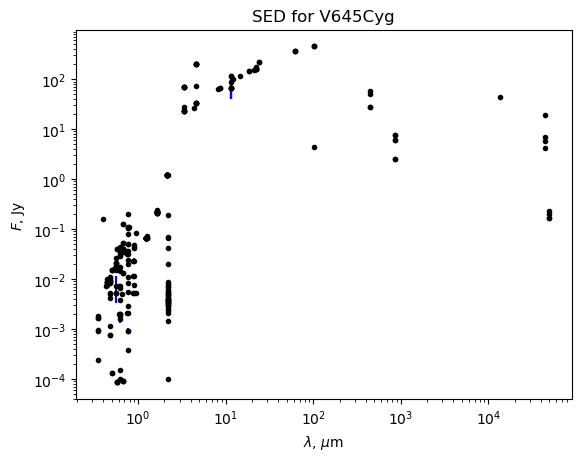

In [42]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pprint
import copy

radius=5
target="V645Cyg"
sed=Table.read(f"https://vizier.cds.unistra.fr/viz-bin/sed?-c={target}&-c.rs={radius}")
pp=pprint.PrettyPrinter(depth=20)
pp.pprint(sed)

x=299792.458/sed["sed_freq"]

x_copy=copy.deepcopy(x)
y_copy=copy.deepcopy(sed["sed_flux"])
filter_copy=copy.deepcopy(sed["sed_filter"])
error_copy=copy.deepcopy(sed["sed_eflux"])


fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(x, sed["sed_flux"], yerr=sed["sed_eflux"], fmt='.', color='black', ecolor='b')
plt.title('SED for'+' '+target)
plt.savefig('sed_nofill.png',dpi=300)
plt.show()
plt.close()

<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6061/2832738041.py:56: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$, $\mu$m')


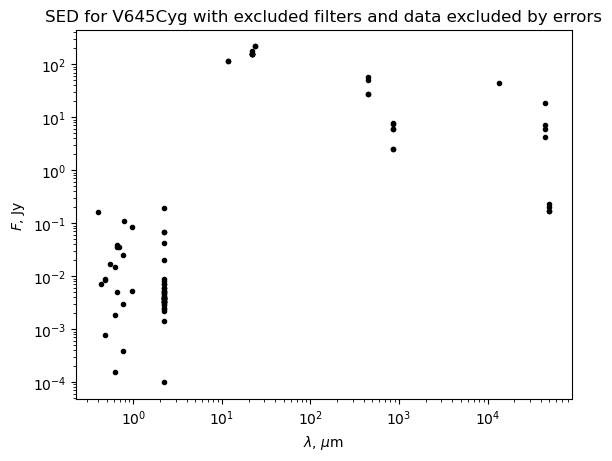

In [44]:
filters_to_exclude = ['Gaia:G','IRAS:100',
    'GALEX:FUV',
    'CTIO/DECam:i',
    'CTIO/DECam:r',
    'CTIO/DECam:g',
    'IRAS:100',
    'SDSS:g',
    'SDSS:u',
    '2MASS:Ks',
    'WISE:W1',
    'Johnson:L',
    'WISE:W2',
    'WISE:W3'
    
]

column_values = sed['sed_eflux']
non_zero_values = column_values[column_values != 0.0]

min_non_zero = np.min(non_zero_values)


def filter_by_name(group_table, filters_to_exclude):
    
    
    for row in group_table:
        if row['sed_filter'] in filters_to_exclude:
            return False  
    
    return True  

def filter_error(group_table):
    for row in group_table:
        if row['sed_eflux']=='--' or row['sed_eflux']>200*min_non_zero:
            return False  
    
    return True  



    
grouped_table = sed.group_by('sed_filter')


filtered_groups = [group for group in grouped_table.groups if filter_by_name(group,filters_to_exclude) and filter_error(group)]


filtered_table = Table(rows=[row for group in filtered_groups for row in group])




filtered_table['col6']=299792.458/filtered_table['col6']

fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(filtered_table['col6'],filtered_table['col7'], yerr=filtered_table['col8'], fmt='.', color='black', ecolor='b')
plt.title('SED for'+' '+target+' '+'with excluded filters and data excluded by errors')
plt.savefig('sed_nof.png',dpi=300)
plt.show()
plt.close()


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                   64 / array data type                                NAXIS   =                    1 / number of array dimensions                     NAXIS1  =                10000                                                  EXTEND  =                    T                                                  DISTANCE=       3.08568025E+21 / Distance assumed for the values, in cm         NWAV    =                  200 / Number of wavelengths                          NAP     =                   20 / Number of apertures                            END                                                                                                                                                                                                                                                                                                                                                                     

<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6061/801406591.py:24: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$, $\mu$m')


None


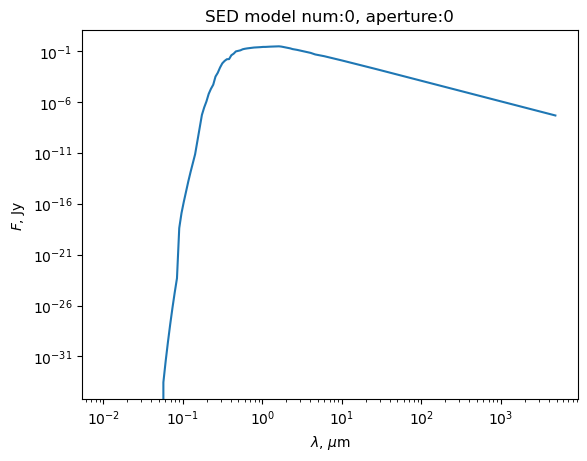

In [45]:
from astropy.io import fits


filename='flux.fits'

hdul = fits.open(filename)
print(hdul[0].header)
data1 = hdul[4].data
print(hdul.info())


specdata = hdul['VALUES'].data
waves=hdul['SPECTRAL_INFO'].data
apertures=hdul['APERTURES'].data
model_names=hdul['MODEL_NAMES'].data
uncertain=hdul['UNCERTAINTIES'].data

#1/r^2

wavelength_values = waves['WAVELENGTH']
frequency_values = waves['FREQUENCY']

fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(wavelength_values,specdata[0][0])
plt.title('SED model num:0, aperture:0')
plt.show()
#подбирать апертуры
#потом строить и выбирать наилучшую модель

In [46]:
import warnings
warnings.filterwarnings("ignore", module='astropy.io.votable.tree')
warnings.filterwarnings("ignore", message='.*unclosed..socket')

from __future__ import print_function, division
import astropy.units as u 
from astropy.coordinates import SkyCoord, ICRS
from astroquery.gaia import Gaia

def gaia_query(ra, dec, radius=5 * u.arcsec):
    '''Return an ADQL query string for Gaia DR2 + geometric distances 
        from Bailer-Jones et al. 2018 '''
    query_string = '''SELECT *, DISTANCE(POINT('ICRS',g.ra, g.dec), 
                    POINT('ICRS', %s, %s)) as r
                    FROM gaiadr2.gaia_source AS g, external.gaiadr2_geometric_distance AS d
                    WHERE g.source_id = d.source_id AND CONTAINS(POINT('ICRS',g.ra, g.dec), 
                    CIRCLE('ICRS',%15.10f, %15.10f,%15.10f))=1 ORDER BY r ASC''' % \
        (ra, dec, ra, dec, radius.to(u.degree).value) 
    return(query_string)


object_name = target
coords = SkyCoord.from_name(object_name)
print(coords.ra.to_string(u.hour), coords.dec.to_string(u.deg))

query_string = gaia_query(coords.ra.to_value(), coords.dec.to_value())
job = Gaia.launch_job(query_string, verbose=False)
a = job.get_results()
if len(a)==0:
    print("No results for star %s." % object_name)
else:
    print("\nThe distance to %s is %0.2f pc, proper motion is %0.1f, %0.1f mas/yr." \
          % (object_name, 1000/a['parallax'][0], a['pmra'], a['pmdec']))

21h39m58.2745512s 50d14m21.042168s

The distance to V645Cyg is 1872.30 pc, proper motion is -7.0, -0.7 mas/yr.


In [52]:

import scipy.stats as stats
from sklearn.metrics import mean_squared_error

def calculate_expected_flux(specdata,model_number,ap_num):

    return 10**3*specdata[model_number][ap_num]*1/(1000/a['parallax'][0])**2


best_model = None
best_p_value = float('inf') 
y = np.array(filtered_table['col7'])



for aperture in range(20):
    for model_number in range(10000):

        expected_flux = calculate_expected_flux(specdata,model_number,aperture)
        #y1 =np.pad(y, (0, 159), mode='constant')
        #y2 =np.pad(y1, (0, 2), mode='constant')
        y1 =np.pad(y, (0, 113), mode='constant')
        y2 =np.pad(y1, (0, 2), mode='constant')
        mse = mean_squared_error(y2, expected_flux)

    
    if mse < best_p_value:
        best_mse = mse
        best_model = model_number
        best_aperture = aperture

print(f"Best Model (Model Number): {best_model}")
print(f"Best mse-value: {best_mse:.5f}")
print(f"Best Aperture: {best_aperture}")


Best Model (Model Number): 9999
Best mse-value: 1452.47144
Best Aperture: 19


In [41]:
'''

from scipy.stats import chisquare
chi=chisquare(f_obs=y2,f_exp=specdata[model_number][aperture])
print(chi)

'''
#y1 =np.pad(y, (0, 159), mode='constant')
#y2 =np.pad(y1, (0, 2), mode='constant')


for i in range (len(uncertain[model_number][aperture])):
    if uncertain[model_number][aperture][i]== 0.0:
        uncertain[model_number][aperture][i]=1e-20

print(uncertain[model_number][aperture])
chi=np.sum((y2-specdata[model_number][aperture])**2/1e-2**2)
print(chi)

[1.51319757e-08 1.72957080e-08 1.97688337e-08 2.25955930e-08
 2.58265533e-08 2.95195104e-08 3.37405268e-08 3.85651049e-08
 4.40795596e-08 5.03825248e-08 5.75867567e-08 6.58211263e-08
 7.52329399e-08 8.59905498e-08 9.82863995e-08 1.12340437e-07
 1.28404068e-07 1.46764663e-07 1.67750642e-07 1.91737428e-07
 2.19154103e-07 2.50491098e-07 2.86308989e-07 3.27248529e-07
 3.74042003e-07 4.27526544e-07 4.88658884e-07 5.58532520e-07
 6.38397466e-07 7.29682370e-07 8.34020170e-07 9.53277322e-07
 1.08958716e-06 1.24538792e-06 1.42346687e-06 1.62700940e-06
 1.85965655e-06 2.12557006e-06 2.42950682e-06 2.77690378e-06
 3.17397530e-06 3.62782407e-06 4.14656915e-06 4.73949012e-06
 5.41719328e-06 6.19180128e-06 7.07717118e-06 8.08914137e-06
 9.24581309e-06 1.05678782e-05 1.20789864e-05 1.38061696e-05
 1.57803242e-05 1.80367751e-05 2.06157401e-05 2.35625776e-05
 2.69304637e-05 3.07783739e-05 3.51752642e-05 4.01998768e-05
 4.59377952e-05 5.24934549e-05 5.99846571e-05 6.85373525e-05
 7.83006035e-05 8.945463

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6061/218110327.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$, $\mu$m')


Model name: ('zzo8rxfX_01')


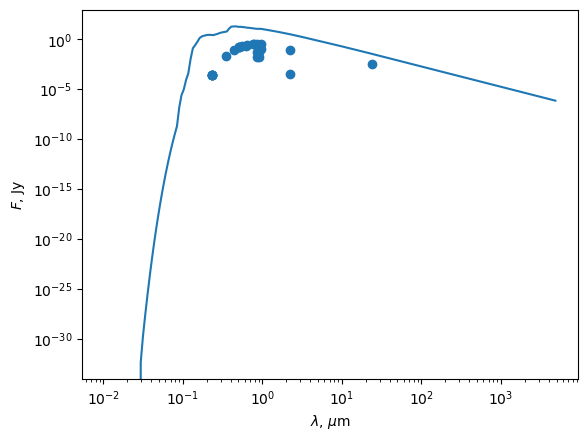

In [22]:
print("Model name:",model_names[best_model])
fig, ax = plt.subplots()
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
ax.set_xscale('log')
ax.set_yscale('log')

#plt.xlim([0,20])
#plt.ylim([0.0001,1000])
plt.scatter(filtered_table['col6'], filtered_table['col7'])
plt.plot(wavelength_values,specdata[best_model][best_aperture])
plt.show()

/tmp/ipykernel_949545/648375351.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  error[error== '--'] = 0


['IRAS:100' 'IRAS:60' 'IRAS:100' 'IRAS:60' 'IRAS:100' 'IRAS:60']


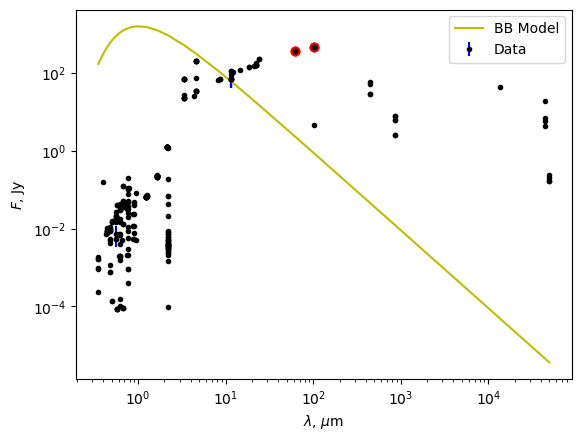

/tmp/ipykernel_949545/648375351.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  filtered_err[filtered_err== '--'] = 0
/tmp/ipykernel_949545/648375351.py:95: RuntimeWarning: invalid value encountered in log
  diff=np.log(filtered_ff_y)-np.log(bb_fitx)


[]


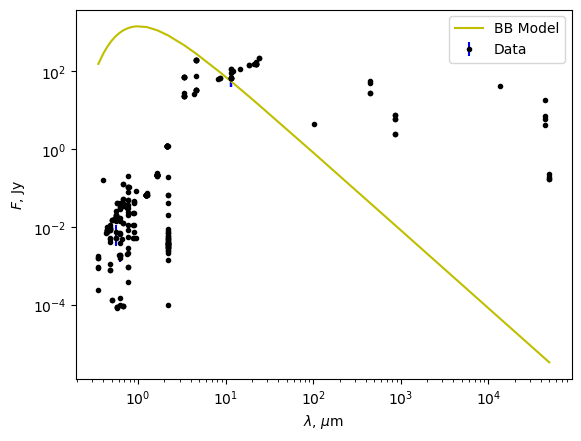

/tmp/ipykernel_949545/648375351.py:128: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  f_err[f_err== '--'] = 0
/tmp/ipykernel_949545/648375351.py:142: RuntimeWarning: invalid value encountered in log
  diff=np.log(f_ff_y)-np.log(bb_fitx)


[]


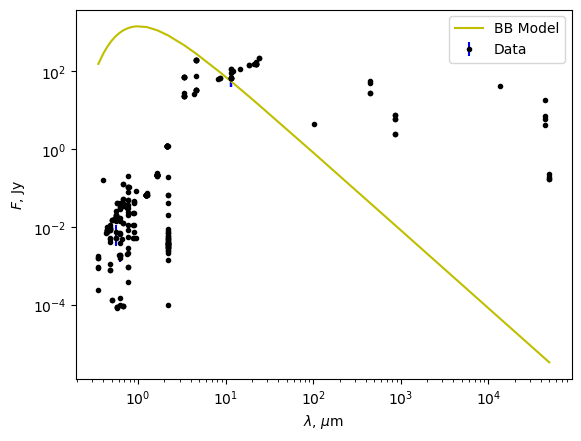

/tmp/ipykernel_949545/648375351.py:174: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  fi_err[fi_err== '--'] = 0


4000.8886332766133 2.605973754816609e-16


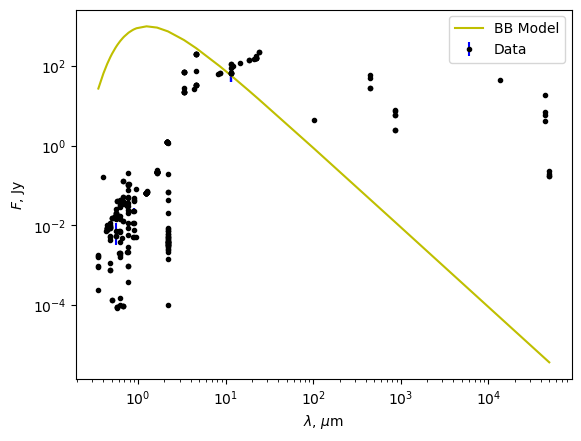

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.physical_models import BlackBody
from astropy.modeling import fitting
from astropy import units as u
from astropy.modeling import models
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.optimize import curve_fit
import copy
from scipy import stats


def planck(lam, T, omega):
    b = models.BlackBody(temperature=T*u.K)
    res =(b(lam * u.um)).to(u.Jy/u.sr) * np.pi*omega
    return res.value



x = np.array(x_copy)#np.array(x)#filtered_freq)#sed['sed_freq']
y = np.array(y_copy)#np.array(sed["sed_flux"])#filtered_flux)#sed['sed_flux']
filter=np.array(filter_copy)#np.array(sed["sed_filter"])#sed['sed_filter']



error=np.array(error_copy)#np.array(sed["sed_eflux"])
error[error== '--'] = 0
error= np.nan_to_num(error, nan=0)
weights = [1/max(_,0.001) for _ in error]




popt, pcov = curve_fit(planck, x, y, p0=(20000, 1e-20), bounds=([5000, 1e-29], [50000,1e-15]),absolute_sigma=True,sigma = weights,method='trf')
w = np.sort(x)
bb_fit = planck(w, popt[0],popt[1])


bb_fitx=planck(x,  popt[0],popt[1])

ff_x = copy.deepcopy(x)
ff_y = copy.deepcopy(y)
ff_e=copy.deepcopy(error)

diff=ff_y#np.log(ff_y)-np.log(bb_fitx)
z_scores = np.abs(stats.zscore(diff))
threshold = 3

idx = np.where(z_scores > threshold)[0]


outliers = ff_y[idx]
out_x=ff_x[idx]

filter1=filter[idx]

print(filter1)


fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(x, y, yerr=error, fmt='.', color='black', ecolor='b', label='Data')
ax.plot(w, bb_fit, color='y', label='BB Model')
ax.scatter(out_x,outliers,c='r')
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
plt.legend()
plt.savefig('sed_fill_outliers1.png',dpi=300)
plt.show()
plt.close()




filtered_ff_y = np.delete(ff_y, idx)
filtered_ff_x = np.delete(ff_x, idx)
filtered_err=np.delete(ff_e,idx)

filtered_err=np.array(filtered_err)
filtered_err[filtered_err== '--'] = 0
filtered_err= np.nan_to_num(filtered_err, nan=0)
weights = [1/max(_,0.001) for _ in filtered_err]


popt, pcov = curve_fit(planck, filtered_ff_x, filtered_ff_y, p0=(8000, 1e-20), bounds=([5000, 1e-29], [40000,1e-15]),absolute_sigma=True,sigma=weights,method='trf')
w = np.sort(filtered_ff_x)
bb_fit = planck(w, popt[0],popt[1])
bb_fitx=planck(filtered_ff_x,  popt[0],popt[1])



diff=np.log(filtered_ff_y)-np.log(bb_fitx)
z_scores = np.abs(stats.zscore(diff))
threshold = 3

idx = np.where(z_scores > threshold)[0]


outliers = filtered_ff_y[idx]
out_x=filtered_ff_x[idx]

filter2=filter[idx]

print(filter2)

fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(filtered_ff_x, filtered_ff_y, yerr=filtered_err, fmt='.', color='black', ecolor='b', label='Data')
ax.plot(w, bb_fit, color='y', label='BB Model')
ax.scatter(out_x,outliers,c='r')
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
plt.legend()
plt.savefig('sed_fill_outliers2.png',dpi=300)
plt.show()
plt.close()



f_ff_y = np.delete(filtered_ff_y, idx)
f_ff_x = np.delete(filtered_ff_x, idx)
f_err=np.delete(filtered_err,idx)
f_err=np.array(f_err)
f_err[f_err== '--'] = 0
f_err= np.nan_to_num(f_err, nan=0)
weights = [1/max(_,0.001) for _ in f_err]




popt, pcov = curve_fit(planck, f_ff_x, f_ff_y, p0=(8000, 1e-20), bounds=([5000, 1e-29], [50000,1e-15]),absolute_sigma=True,sigma=weights,method='trf')
w = np.sort(f_ff_x)
bb_fit = planck(w, popt[0],popt[1])
bb_fitx=planck(f_ff_x,  popt[0],popt[1])



diff=np.log(f_ff_y)-np.log(bb_fitx)
z_scores = np.abs(stats.zscore(diff))
threshold = 3

idx = np.where(z_scores > threshold)[0]


outliers = f_ff_y[idx]
out_x=f_ff_x[idx]
filter3=filter[idx]

print(filter3)


fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(f_ff_x, f_ff_y, yerr=f_err, fmt='.', color='black', ecolor='b', label='Data')
ax.plot(w, bb_fit, color='y', label='BB Model')
ax.scatter(out_x,outliers,c='r')
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
plt.legend()
plt.savefig('sed_fill_outliers3.png',dpi=300)
plt.show()
plt.close()


fi_ff_y = np.delete(f_ff_y, idx)
fi_ff_x = np.delete(f_ff_x, idx)
fi_err=np.delete(f_err,idx)
fi_err=np.array(fi_err)
fi_err[fi_err== '--'] = 0
fi_err= np.nan_to_num(fi_err, nan=0)
weights = [1/max(_,0.001) for _ in fi_err]



popt, pcov = curve_fit(planck, fi_ff_x, fi_ff_y, p0=(8000, 1e-20), bounds=([4000, 1e-29], [50000,1e-15]),absolute_sigma=True,sigma=weights,method='trf')
w = np.sort(fi_ff_x)
bb_fit = planck(w, popt[0],popt[1])
bb_fitx=planck(fi_ff_x,  popt[0],popt[1])

print(*popt)
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(fi_ff_x, fi_ff_y, yerr=fi_err, fmt='.', color='black', ecolor='b', label='Data')
ax.plot(w, bb_fit, color='y', label='BB Model')
#ax.scatter(out_x,outliers,c='r')
ax.set_xlabel('$\lambda$, $\mu$m')
ax.set_ylabel('$F$, Jy')
plt.legend()
plt.savefig('sed_fill_outliers_fin.png',dpi=300)
plt.show()
plt.close()

